In [2]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal
from numpy.fft import fft


%matplotlib inline



451199
451199
Timestep = 25.0 ps


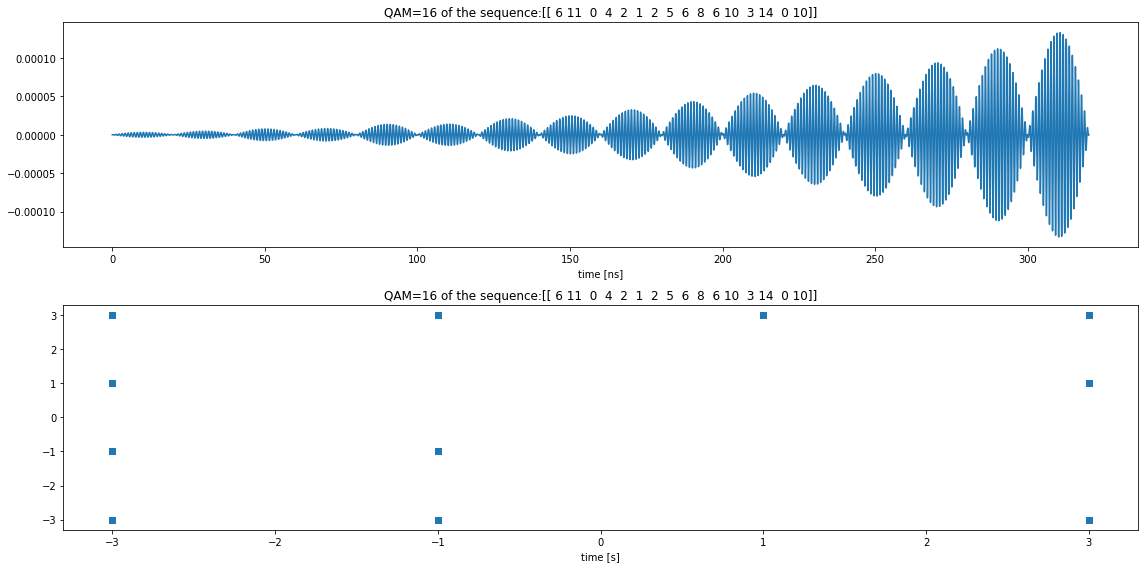

In [47]:
# 16 QAM RF signal Generation 
f0=1e+9  # RF freq.
fs = 40e+9  # sampling rate: this is not ADC sampling rate
baud = f0/20  # symbol rate  <-> corresponds to signal bandwidth at RF
Ns = int(fs/baud)  # samples per symbol

#code = { 2: -3+3j, 6: -1+3j, 14: 1+3j, 10: 3+3j,
#        3: -3+1j, 7: -1+1j, 15: 1+1j, 11: 3+1j,
#        1: -3-1j, 5: -1-1j, 13: 1-1j, 9: 3-1j,
#        0: -3-3j, 4: -1-3j, 12: 1-3j, 8: 3-3j}

Nbits = 500  # number of bits actually used: number of symbols sent
N = Nbits * Ns  #Total number of samples
  
Ndisp = 16 ;   #number of bits to display

code = np.array((-3-3j, -3-1j,-3+3j,-3+1j,-1-3j,-1-1j,-1+3j,-1+1j,+3-3j,+3-1j,+3+3j,+3+1j,1-3j,+1-1j,1+3j,1+1j))
#code = np.array((-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j,-3-3j,-1-3j))

np.random.seed(seed=1)
bits = np.int16(np.random.rand(Nbits,1)*16) 

message = zeros(N, dtype='complex')
symbol = code[bits].ravel()
message[::Ns] = symbol

# Convolve
h = np.ones(Ns)
message = signal.fftconvolve(message,h,mode='full')

t = r_[0.0:len(message)]/(fs)
QAM = message*exp(1j*2*pi*f0*t)
#QAM = 3*exp(1j*2*pi*f0*t)
QAM_real = np.real(QAM)
QAM_imag= np.imag(QAM)

#Frequency response of QAM

QAM_f = (np.fft.fft(QAM_real))
f = r_[0:len(QAM_f)]/len(QAM_f)*fs


# Raised cosine pulse shaping
imp = zeros(N,dtype='complex')
imp[::Ns] = code[bits].ravel()

h_s = signal.firwin(Ns*64,1.0/Ns)

imp_sinc = signal.fftconvolve(imp,h_s,mode='full')
t = r_[0.0:len(imp_sinc)]/fs



#shaped QAM
QAM_s = imp_sinc*exp(1j*2*pi*f0*t)
#QAM_s = exp(1j*2*pi*f0*t)+exp(1j*2*pi*1.05*f0*t)
QAM_s_real = np.real(QAM_s)
#Frequency response of shaped QAM
QAM_sf = (np.fft.fft(QAM_s_real))


f = r_[0:len(imp_sinc)]/len(imp_sinc)*fs
print(len(imp_sinc))

print(len(QAM_s))

print('Timestep =', 1e12*1/fs,'ps')

fig = plt.figure(figsize = (16,8))
plt.subplot(211)
#plt.plot(t[:Ns*Ndisp]*1e+9,QAM_real[:Ns*Ndisp])
plt.plot(t[:Ns*Ndisp]*1e+9,(QAM_s_real[:Ns*Ndisp]))
#plt.plot(t[:Ns*Ndisp],np.imag(message[:Ns*Ndisp]))
plt.xlabel('time [ns]')
plt.title("QAM=16 of the sequence:"+ np.array2string(np.transpose(bits[:Ndisp])))

plt.subplot(2,1,2)
#plt.plot(t[:Ns*Ndisp],QAM_imag[:Ns*Ndisp])
plt.plot(np.real(message[:Ns*Ndisp]),np.imag(message[:Ns*Ndisp]),'s')
#plt.plot(np.real(code),np.imag(code), 's')
#plt.plot(t[:Ns*Ndisp],np.imag(message[:Ns*Ndisp]))
plt.xlabel('time [s]')
plt.title("QAM=16 of the sequence:"+ np.array2string(np.transpose(bits[:Ndisp])))
plt.tight_layout()

In [48]:
def Tshift(arr,tau):
    num = int(tau*fs)
    arr=np.roll(arr,num)
    if num<0:
         np.put(arr,range(len(arr)+num,len(arr)),0)
    elif num > 0:
         np.put(arr,range(num),0)
    return arr



# Channel Model 

def H_ch_Tshift(A, tau, IN):          #Take Complex value input and give complex out
    
    H_ch_OUT= zeros(len(IN),dtype='complex')
  
    for i in range(len(A)):
        H_ch_OUT += A[i]*Tshift(IN,tau[i])
       

    return H_ch_OUT


# Band-pass Filtering at f0 with 3dB cut-off freq of fl, fh
def BPF(order, fl, fh, fs):
    nyq = 0.5*fs
    low=fl/nyq
    high=fh/nyq
    b,a = signal.butter(order, [low, high], btype='band')
    return b,a

# Low-pass Filter at cutoff freq of fc
def LPF(order, fc, fs):
    nyq = 0.5*fs
    fc_norm=fc/nyq
    b,a = signal.butter(order, fc_norm, btype='low')
    return b,a


# Phase shifter introducing phase (deg) of 'j*phase', IN: complex input, complex out.
def PS_OUT(phase, IN):
    OUT = IN*exp(1j*phase*np.pi/180)        
    return OUT



# CX tab
def Tab_Tshift(tau, W_I, W_Q, phase, IN):     #Just gives frequency impulse response of one Tab with same dimension as IN
    H_Tab_OUT= zeros(len(IN),dtype='complex')
    for i in range(len(tau)):
        H_Tab_OUT += (W_I[i]+exp(1j*phase*np.pi/180)*W_Q[i])*Tshift(IN, tau[i])
        #H_Tab_OUT += Tshift(IN, tau[i])
    return H_Tab_OUT

# DSP
def r(u,k,N,UpS,TauS):
    Sum = 0

    for n in range(N):
        t=0
        if n*UpS + k*TauS > (N-1)*UpS:
            t = n*UpS + k*TauS - N*UpS
        elif n*UpS + k*TauS < 0:
            t = n*UpS + k*TauS + N*UpS
        else:
            t = n*UpS + k*TauS
        Sum += u[t]*np.conjugate(u[n*UpS])
    return Sum/N

def p(u,d,k,N,UpS,TauS):
    Sum = 0
    for n in range(N):
        if n*UpS + k*TauS < 0:
            t = n*UpS + k*TauS + N*UpS
        else:
            t = n*UpS + k*TauS
        Sum += u[t]*np.conjugate(d[n*UpS])
    return Sum/N

In [73]:
# ******************Testbench for wireless channel *************


b,a = BPF(4,0.85e9,1.15e+9, fs)
w, h = signal.freqs(b, a)
TXSig_real=signal.lfilter(b,a,QAM_s_real)  #no delay : filtfilt, yesdelay: lfilter

TXSig_fft = (np.fft.fft(TXSig_real))

#Channel response (Define here)

A_ch=[0.1,0.05, 0.0025, 0.00125]
tau_ch = [10e-9, 20e-9, 30e-9, 40e-9]

RXSig_real = H_ch_Tshift(A_ch, tau_ch, TXSig_real)
RXSig_fft=np.fft.fft(RXSig_real[:len(TXSig_real)])


# Testbench for multiple cancellor branches
Num_tab = 5
tau_unit=10e-9
Array = np.linspace(0,Num_tab-1,Num_tab)
tau=np.dot(tau_unit,Array)

####### Downconversion
RXSig_BB = RXSig_real*exp(-1j*2*pi*f0*t)
QAM_s_BB = QAM_s_real*exp(-1j*2*pi*f0*t)

####### Low-pass filtering  
b,a = LPF(4,2*baud,fs)
w, h = signal.freqs(b, a)
RXSig_BB_F=signal.lfilter(b,a,RXSig_BB)  #no delay : filtfilt, yesdelay: lfilter
QAM_s_BB_F=signal.lfilter(b,a,QAM_s_BB)  #no delay : filtfilt, yesdelay: lfilter

####### DSP part for Wiener Solution #####

Update_dt = 1/fs     #Update time step for Wiener calculation  -> Use 1/fs for continuous time case
Update_step = int(Update_dt*fs)
tau_step = int(tau_unit*fs)


M = len(tau)
R= np.zeros((M,M),dtype='complex')
P= np.zeros((M,1),dtype='complex')
u = QAM_s_BB_F[len(QAM_s_BB)//8:]
d = RXSig_BB_F[len(QAM_s_BB)//8:]
W=np.zeros((M,1),dtype='complex')

for i in range(M):
    for j in range(M):
        R[i,j] = r(u,j-i,(7*len(QAM_s_BB)//(8*Update_step)), Update_step, tau_step)
    P[i]=p(u,d,-i,7*len(QAM_s_BB)//(8*Update_step), Update_step, tau_step)
W = np.conjugate(np.linalg.inv(R)@P)

W_I = np.real(W)
W_Q = np.imag(W)

# Find Eigenvalues of R
eigenvalues = np.linalg.eigvals(R)
print(eigenvalues)
print('0<mu<',1/np.trace(R),'<',1/np.abs(np.max(eigenvalues)))
print('eigenvalue spread =', np.abs(np.divide(np.max(eigenvalues),np.min(eigenvalues))))



[7.68062257e-06+2.15414409e-23j 6.80518529e-06+2.16373614e-22j
 3.43178176e-06-7.30369630e-23j 4.82395090e-07+6.99354238e-23j
 1.69381956e-08+3.21051856e-22j]
0<mu< (54297.887059813555+0j) < 130197.77905556
eigenvalue spread = 453.4498679149801


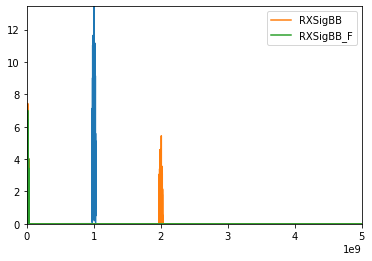

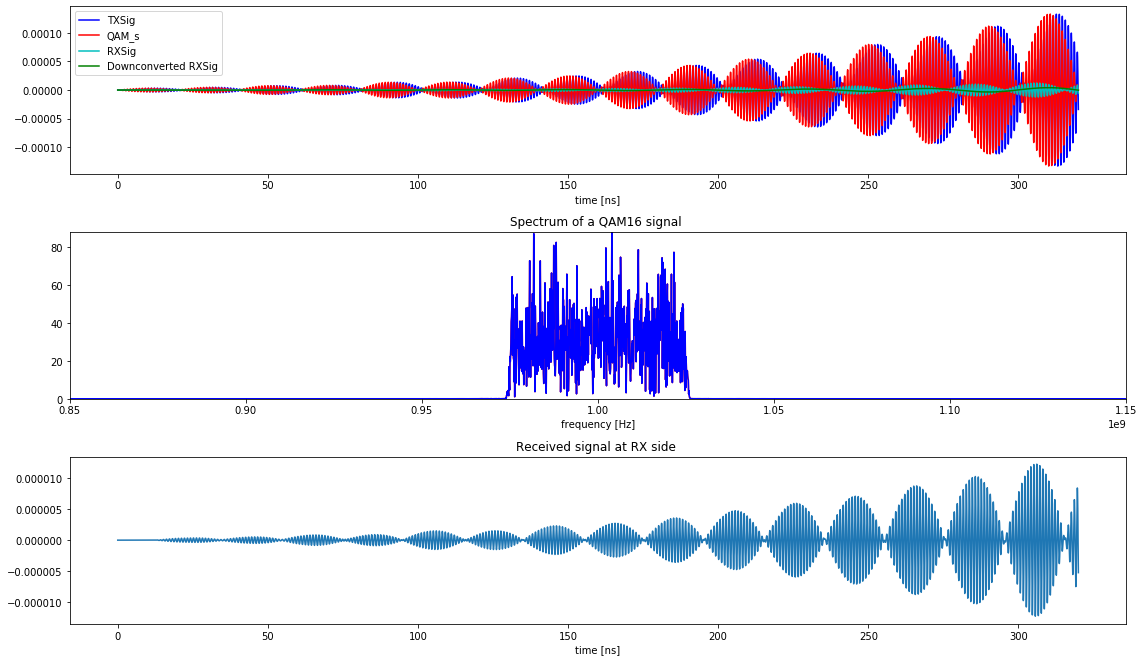

In [74]:

freq_RXSig = r_[0:len(RXSig_fft)]/len(RXSig_fft)*fs
plt.plot(freq_RXSig,np.abs(RXSig_fft))
plt.plot(freq_RXSig,np.fft.fft(np.real(RXSig_BB)),label='RXSigBB')
plt.plot(freq_RXSig,np.fft.fft(np.real(RXSig_BB_F)),label='RXSigBB_F')
plt.legend()
plt.axis((0,5e9,0,max(abs(RXSig_fft))))



fig = plt.figure(figsize = (16,12))
plt.subplot(411)
plt.plot(1e+9*r_[0.0:len(TXSig_real[:Ns*Ndisp])]/fs, np.real(TXSig_real[:Ns*Ndisp]), 'b',label = 'TXSig')
plt.plot(1e+9*t[:Ns*Ndisp],QAM_s_real[:Ns*Ndisp],'r', label = 'QAM_s')
plt.plot(1e+9*t[:Ns*Ndisp],RXSig_real[:Ns*Ndisp],'c', label = 'RXSig')
plt.plot(1e+9*t[:Ns*Ndisp],np.real(RXSig_BB_F[:Ns*Ndisp]),'g', label = 'Downconverted RXSig')
plt.xlabel('time [ns]')
plt.legend()

freq_TXSig = r_[0:len(TXSig_fft)]/len(TXSig_fft)*fs
plt.subplot(412)
plt.plot(f,abs(QAM_sf[0:len(QAM_sf)]), 'r')
plt.plot(freq_TXSig,abs(TXSig_fft[0:len(TXSig_fft)]), 'b')
plt.xlabel('frequency [Hz]')
plt.title('Spectrum of a QAM16 signal ')
plt.axis((0.85e+9,1.15e9,0,max(abs(TXSig_fft))))




plt.subplot(413)
#plt.plot(r_[0.0:len(h_ch_env[:Ns*Ndisp])]/fs, np.real(h_ch_env[:Ns*Ndisp]))
#plt.plot(r_[0.0:len(RXSig[:Ns*Ndisp])]/fs, np.real(RXSig[:Ns*Ndisp]))
plt.plot(1e+9*r_[0.0:len(RXSig_real[:Ns*Ndisp])]/fs, RXSig_real[:Ns*Ndisp])

plt.xlabel('time [ns]')
plt.title('Received signal at RX side ')
#plt.plot(freq_TXSig,abs(H_ch_env[0:len(H_ch_env)//2]))




plt.tight_layout()


(4.366221057389872e-06-7.806412198027456e-06j)
1.9217110643341536e-16


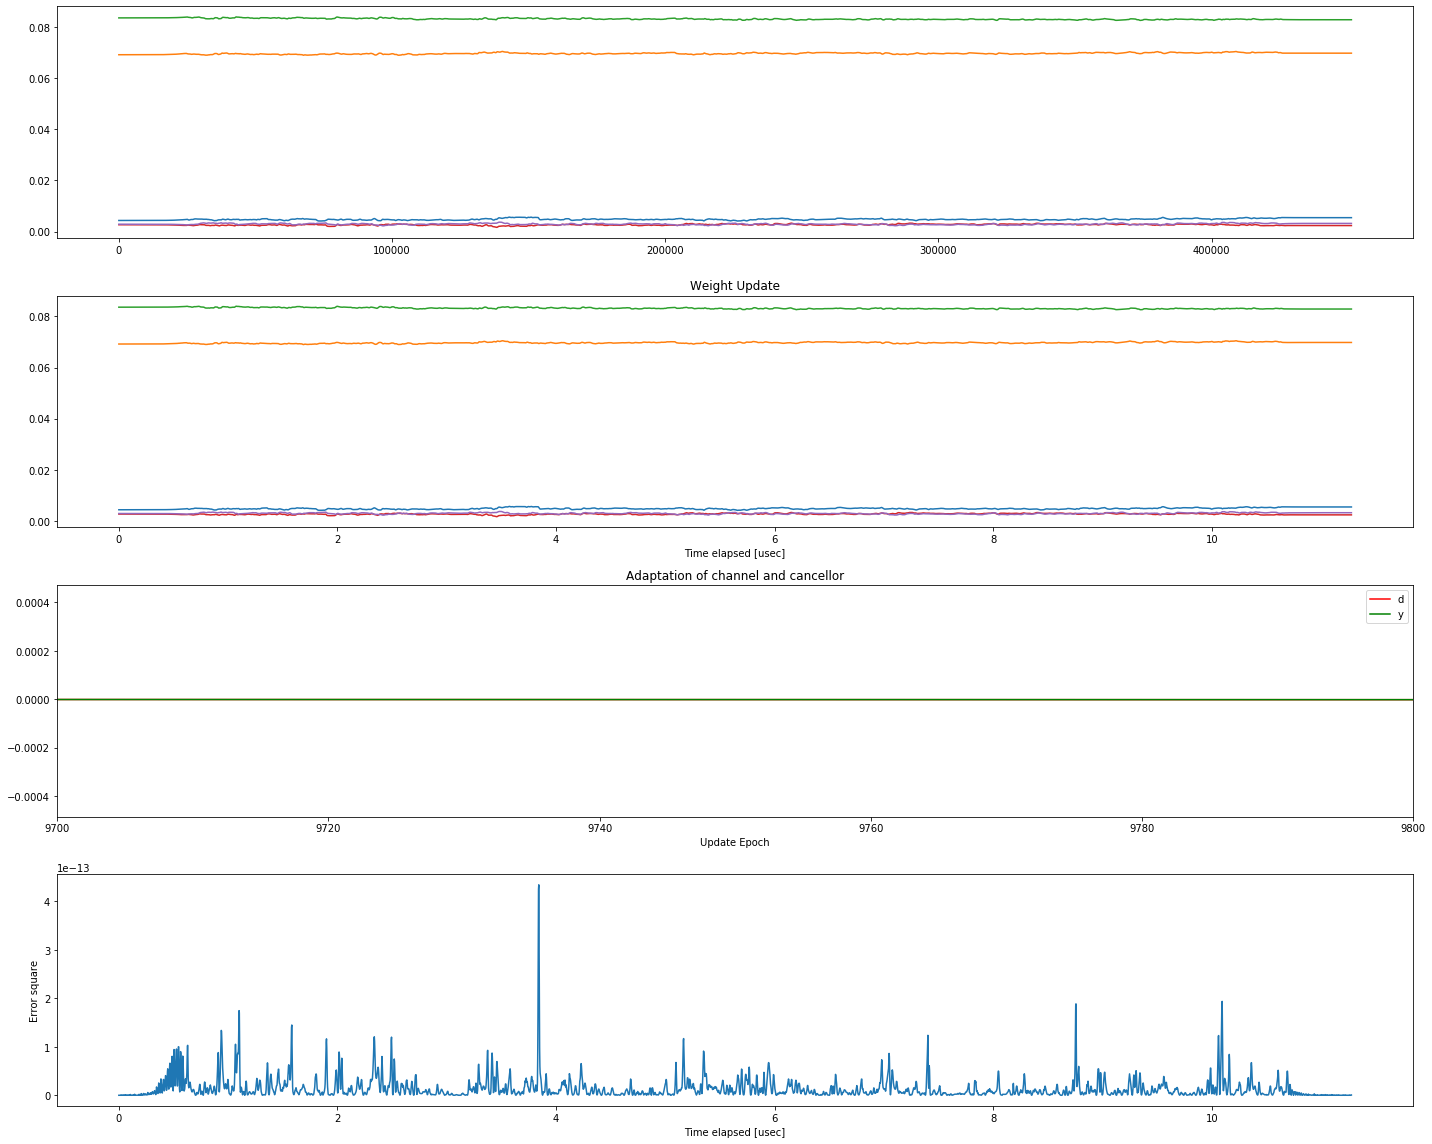

In [86]:
# LMS Algorithm


N_step = Update_step
tau_step = int(tau_unit*fs)
N_LMS = len(RXSig_real)//N_step
W_LMS = np.zeros((M,N_LMS),dtype='complex')

#Wiener initialization
W_LMS[:,0]=np.reshape(W,(len(tau)))

d = RXSig_BB_F[:N_LMS*N_step:N_step] #- np.average(RXSig[:N_LMS*N_step:N_step])
print(np.average(RXSig_BB_F[:N_LMS*N_step:N_step]))
y = np.zeros(N_LMS, dtype='complex')
mu = 200

e = np.zeros(N_LMS, dtype='complex')

e[0] = d[0]-y[0]

for i in range(N_LMS-1):
    #if i%200 ==150:
    #    mu*=0.9
    
    for k in range(len(tau)):
        if i*N_step-k*tau_step<0:
            y[i] += 0
        else:
            y[i] += W_LMS[k,i]*QAM_s_BB_F[i*N_step-k*tau_step]
    e[i] = d[i] - y[i]
    for j in range(len(tau)):
        if i*N_step-j*tau_step<0:
            W_LMS[j,i+1] = W_LMS[j,i]
        else:
            W_LMS[j,i+1] = W_LMS[j,i] + 8*mu*e[i]*np.conjugate(QAM_s_BB_F[i*N_step-j*tau_step])
        
W_LMS_final = np.reshape(W_LMS[:,N_LMS-1],(M,-1))        
#print('W_LMS=',W_LMS_final)
#print('W_Wiener=',W)
n = np.arange(N_LMS)

fig = plt.figure(figsize = (20,16))
plt.subplot(411) 
for i in range(len(tau)):
    plt.plot(n,np.absolute(W_LMS[i,:]), label="real of W_0"+str(i))

#plt.legend()
plt.subplot(412)
for i in range(len(tau)):
    plt.plot(1e+6*n[::100]*Update_dt,np.absolute(W_LMS[i,::100]), label="real of W_0"+str(i))
    
plt.title("Weight Update")
plt.xlabel('Time elapsed [usec]')


plt.subplot(413)
plt.plot(n[::10],d[::10], 'r', label ='d')
plt.plot(n[::10],y[::10], 'g', label ='y')
plt.xlabel('Update Epoch')
plt.title('Adaptation of channel and cancellor')
plt.legend()
#plt.axis((7800,8000,-max(abs(y)),max(abs(y))))
plt.xlim(9700,9800)
#plt.semilogy(n,np.square(np.abs(e)))

plt.subplot(414)
plt.plot(n[::100]*1e+6*Update_dt,np.square(np.abs(e[::100])))
plt.ylabel('Error square')
plt.xlabel('Time elapsed [usec]')
print(np.average(np.square(np.abs(e[-500:-10]))))


plt.tight_layout()

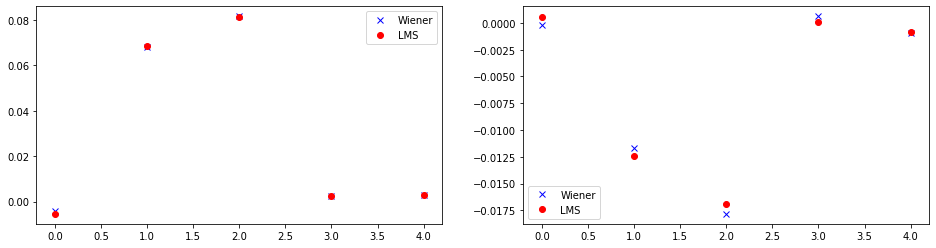

In [87]:

fig = plt.figure(figsize = (16,4))
plt.subplot(121) 
plt.plot(np.real(W),'bx',label='Wiener')
plt.plot(np.real(W_LMS_final),'ro', label = 'LMS')
plt.legend()

plt.subplot(122)
plt.plot(np.imag(W),'bx',label ='Wiener')
plt.plot(np.imag(W_LMS_final),'ro', label = 'LMS')
plt.legend()


Total Cancellation for Wiener[dB]: 49.5445092847375
Total Cancellation for LMS[dB]: 44.91811342623351


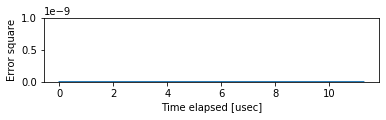

In [98]:
#### Cancellation in effect ####


#Cancellor output signal
CXSig_real = np.real(Tab_Tshift(tau, W_I, W_Q, 90, QAM_s))
CXSig_fft=np.fft.fft(CXSig_real)

CXSig_LMS_real = np.real(Tab_Tshift(tau, np.real(W_LMS_final), np.imag(W_LMS_final), 90, QAM_s))
CXSig_LMS_fft=np.fft.fft(CXSig_LMS_real)

#Error signal 
ESig_real=RXSig_real-CXSig_real
ESig_fft=np.fft.fft(ESig_real)

ESig_LMS_real=RXSig_real-CXSig_LMS_real
ESig_LMS_fft=np.fft.fft(ESig_LMS_real)

SqrSum_RXSig = np.sum(np.square(abs(RXSig_fft)))
SqrSum_ESig = np.sum(np.square(abs(ESig_fft)))
SqrSum_ESig_LMS = np.sum(np.square(abs(ESig_LMS_fft)))

CX_dB = 10*np.log10(np.divide(SqrSum_RXSig,SqrSum_ESig))
CX_LMS_dB = 10*np.log10(np.divide(SqrSum_RXSig,SqrSum_ESig_LMS))


plt.subplot(313)
plt.plot(n[::100]*1e+6*Update_dt,np.square(np.abs(e[::100])))
plt.ylabel('Error square')
plt.xlabel('Time elapsed [usec]')
plt.ylim(0,1e-9)

# Total cancellation power is across all available frequency band (This is not inband of signals)

print('Total Cancellation for Wiener[dB]:', CX_dB)
print('Total Cancellation for LMS[dB]:', CX_LMS_dB)

D:\Python\Anaconda3\envs\PyTorch\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


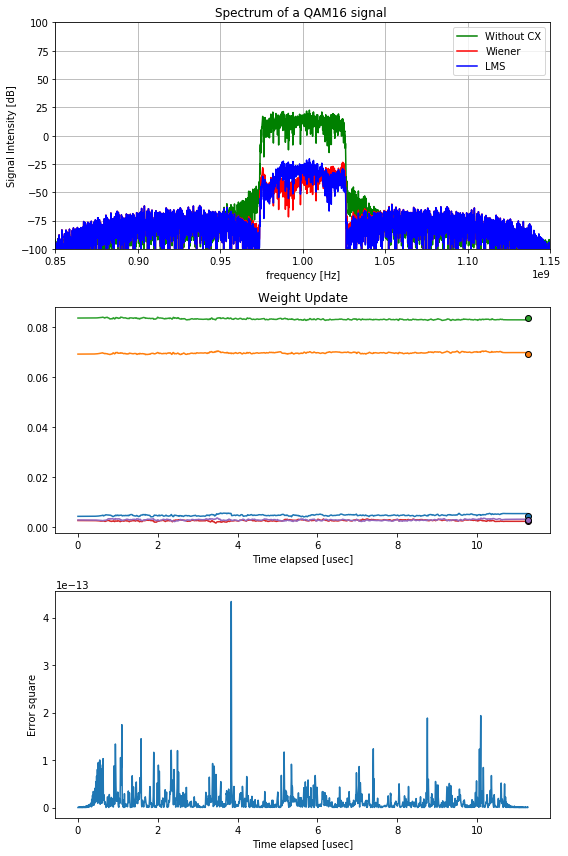

In [99]:
fig = plt.figure(figsize = (8,12))
plt.subplot(311)

plt.plot(r_[0:len(RXSig_fft)]/len(RXSig_fft)*fs, 20*np.log10(np.abs(RXSig_fft)), 'g', label = 'Without CX')

plt.plot(r_[0:len(ESig_fft)]/len(ESig_fft)*fs, 20*np.log10(np.abs(ESig_fft)), 'r', label = 'Wiener')
plt.plot(r_[0:len(ESig_fft)]/len(ESig_fft)*fs, 20*np.log10(np.abs(ESig_LMS_fft)), 'b', label = 'LMS')

plt.xlabel('frequency [Hz]')
plt.ylabel('Signal Intensity [dB]')
plt.title('Spectrum of a QAM16 signal ')
plt.legend()
plt.xlim(0.85e9,1.15e9)
plt.ylim(-100,100)
plt.grid()

plt.subplot(312)
for i in range(len(tau)):
    plt.plot(1e+6*n[::100]*Update_dt,np.absolute(W_LMS[i,::100]), label="W_"+str(i))
   
    
plt.gca().set_prop_cycle(None)
for i in range(len(tau)):
    
    plt.plot(len(n)*1e+6*Update_dt,np.absolute(W[i]), 'o',markeredgecolor="black")

plt.title("Weight Update")
plt.xlabel('Time elapsed [usec]')
#plt.legend()

plt.subplot(313)
plt.plot(n[::100]*1e+6*Update_dt,np.square(np.abs(e[::100])))
plt.ylabel('Error square')
plt.xlabel('Time elapsed [usec]')
#plt.ylim(0,1e-11)
plt.tight_layout()

D:\Python\Anaconda3\envs\PyTorch\lib\site-packages\ipykernel_launcher.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


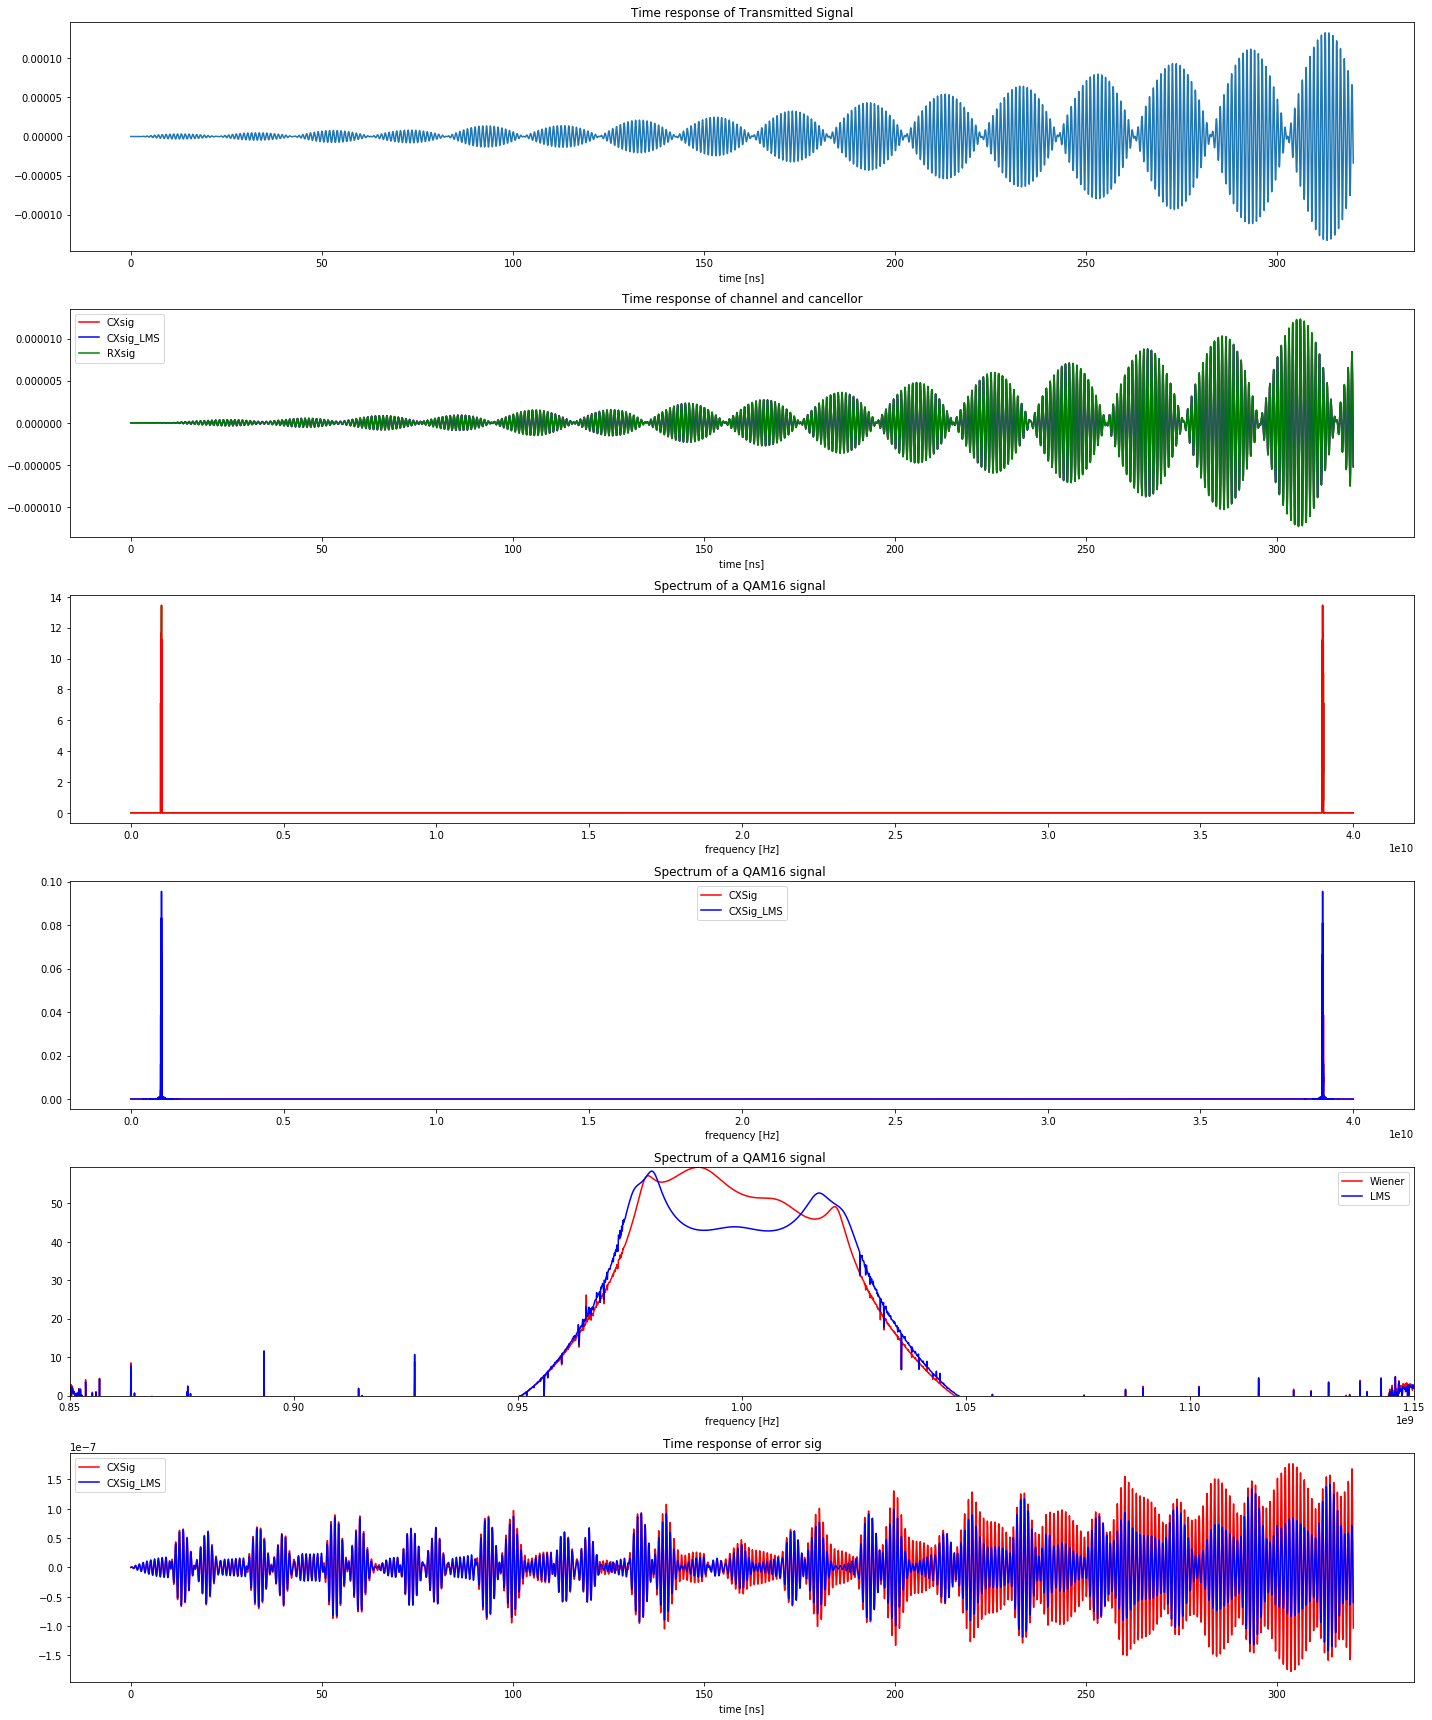

In [100]:
#### Cancellation in effect ####

Suppression = 20*np.log10(np.divide(abs(RXSig_fft),abs(ESig_fft)))
Suppression_LMS = 20*np.log10(np.divide(abs(RXSig_fft),abs(ESig_LMS_fft)))


fig = plt.figure(figsize = (20,24))
plt.subplot(611) 
plt.plot(1e+9*r_[0.0:len(TXSig_real[:Ns*Ndisp])]/fs, np.real(TXSig_real[:Ns*Ndisp]))
plt.xlabel('time [ns]')
plt.title('Time response of Transmitted Signal')

plt.subplot(612)
plt.plot(1e+9*r_[0.0:len(CXSig_real[:Ns*Ndisp])]/fs, np.real(CXSig_real[:Ns*Ndisp]), 'r', label='CXsig')
plt.plot(1e+9*r_[0.0:len(CXSig_LMS[:Ns*Ndisp])]/fs, np.real(CXSig_LMS[:Ns*Ndisp]), 'b', label='CXsig_LMS')
plt.plot(1e+9*r_[0.0:len(RXSig_real[:Ns*Ndisp])]/fs, np.real(RXSig_real[:Ns*Ndisp]), 'g', label='RXsig')
#plt.plot(r_[0.0:len(RXSig[:Ns*Ndisp])]/fs, np.real(RXSig[:Ns*Ndisp]), 'g')

plt.xlabel('time [ns]')
plt.title('Time response of channel and cancellor')
plt.legend()

plt.subplot(613)

plt.plot(r_[0:len(RXSig_fft)]/len(RXSig_fft)*fs, abs(RXSig_fft[0:len(RXSig_fft)]), 'g')
plt.plot(r_[0:len(CXSig_fft)]/len(CXSig_fft)*fs, abs(CXSig_fft[0:len(CXSig_fft)]), 'r')
plt.xlabel('frequency [Hz]')
plt.title('Spectrum of a QAM16 signal ')
#plt.axis((0.85e9,1.15e9,0,max(abs(RXSig_fft))))

plt.subplot(614)
#np.pad(QAM_f, (2, 3), 'constant')

plt.plot(r_[0:len(ESig_fft)]/len(ESig_fft)*fs, abs(ESig_fft[0:len(ESig_fft)]), 'r', label = 'CXSig')
plt.plot(r_[0:len(ESig_LMS_fft)]/len(ESig_fft)*fs, abs(ESig_LMS_fft[0:len(ESig_fft)]), 'b', label = 'CXSig_LMS')
plt.xlabel('frequency [Hz]')
plt.title('Spectrum of a QAM16 signal ')
#plt.axis((0.85e9,1.15e9,0,0.1*max(abs(RXSig_fft))))
plt.legend()

plt.subplot(615)
#np.pad(QAM_f, (2, 3), 'constant')

plt.plot(r_[0:len(ESig_fft)]/len(ESig_fft)*fs, Suppression, 'r', label = 'Wiener')
plt.plot(r_[0:len(ESig_fft)]/len(ESig_fft)*fs, Suppression_LMS, 'b', label = 'LMS')
#plt.plot(r_[0:len(ESig_LMS_fft)]/len(ESig_fft)*fs, abs(ESig_LMS_fft[0:len(ESig_fft)]), 'b', label = 'CXSig_LMS')
plt.xlabel('frequency [Hz]')
plt.title('Spectrum of a QAM16 signal ')
plt.axis((0.85e9,1.15e9,0,np.max([Suppression,Suppression_LMS])))
plt.legend()


plt.subplot(616)
plt.plot(1e+9*r_[0.0:len(ESig_real[:Ns*Ndisp])]/fs, np.real(ESig_real[:Ns*Ndisp]), 'r', label = 'CXSig')
plt.plot(1e+9*r_[0.0:len(ESig_LMS_real[:Ns*Ndisp])]/fs, np.real(ESig_LMS_real[:Ns*Ndisp]), 'b', label = 'CXSig_LMS')

#plt.plot(r_[0.0:len(RXSig[:Ns*Ndisp])]/fs, np.real(RXSig[:Ns*Ndisp]), 'g')

plt.xlabel('time [ns]')
plt.title('Time response of error sig')
plt.legend()



plt.tight_layout()


